In [18]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [19]:
import os
basePath = '/content/gdrive/My Drive/'
os.chdir(basePath + 'YahooAnswers/yahoo_answers_csv')

## S-BERT

In [ ]:
!pip install --quiet sentence-transformers

     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 2.5MB 4.8MB/s 
     |████████████████████████████████| 1.2MB 16.1MB/s 
     |████████████████████████████████| 901kB 19.6MB/s 
     |████████████████████████████████| 3.3MB 25.9MB/s 
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


In [ ]:
from sentence_transformers import SentenceTransformer
device = 'cuda'
evalModel = SentenceTransformer('bert-base-nli-mean-tokens')
evalModel = evalModel.to(device)

100%|██████████| 405M/405M [00:23<00:00, 16.9MB/s]


## USE

In [ ]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [ ]:
# Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
modelEval2 = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return modelEval2(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Helper functions

In [ ]:
import torch
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [ ]:
def getEmbedding(sntcBatch):
    # return evalModel.encode(sntcBatch, convert_to_tensor=True)
    return torch.tensor(np.asarray(embed(sntcBatch)))

In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Similar to the above, for whole documents instead of sentences.
# The embedding of the document is calculated as the average of all its sentences
def getDocumentEmbedding(documentBatch):
  docEmbeddings = torch.zeros(len(documentBatch), 512)
  for (i, doc) in enumerate(documentBatch):
    if i%10000 == 0:
      print(i)
    sentences = tokenize.sent_tokenize(doc)
    sentEmbeddings = getEmbedding(sentences)
    avgEmbedding = torch.mean(sentEmbeddings, axis=0)
    docEmbeddings[i, :] = avgEmbedding
  return docEmbeddings

In [ ]:
def getSimilarity(a, b):
  return cos(a, b)
  # return np.linalg.norm(a - b, -1)

In [ ]:
def evaluateEmbeddingsMultiple(generatedEmbeddingsArr, evaluationEmbeddingsArr):
  nSentences = len(generatedEmbeddingsArr)
  nKeywords  = len(evaluationEmbeddingsArr)
  scores = torch.zeros(size=(nSentences, 1))

  for i in range(nSentences):
    for j in range(nKeywords):
      scores[i] += getSimilarity(evaluationEmbeddingsArr[j], generatedEmbeddingsArr[i]) 
    scores[i] = scores[i]/nKeywords

  score = torch.mean(scores)
  std = torch.std(scores)

  return score, std, scores

In [ ]:
def choose_from_top(probs, n=40):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
device = 'cpu'
model = model.to(device)

In [ ]:
  def generate(model=model, prompt='<|endoftext|>', nSentences=20, showOnlyFinished=0, n=40):
  #   """
  #   Function GENERATE()
  #   INPUTS:
  #     model           : Pytorch Model     - Pytorch Language Model to use
  #     prompt          : String            - User prompt 
  #     nSentences      : Int               - Number of sentences to generate
  #     showOnlyFinished: Boolean           - Wether to display only generated sentences that end with <|endoftext|>
  #     n               : Int               - top-n sampler parameter. Set higher for more diversity, but too high will produce nonsense

  #   AUTHOR: Kitsios Konstantinos
  #   """

      # Turn model in evaluation mode(deactivate dropouts etc)
      model.eval()
      # Number of sentences generated so far
      gen_num = 0
      # Array to return
      generatedSentenceArr = []
      # Tokenizer(Suppose GPT2 model)
      tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

      with torch.no_grad():

              # How many sentences to generate
              for gen_idx in range(nSentences):
                  # Generation not finished yet
                  gen_finished = False

                  # Define custom prompt
                  cur_ids = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

                  # Predict the next 50 words(unless EOS token encountered)
                  for i in range(10):
                      # Forward pass the model to get outputs
                      outputs = model(cur_ids, labels=cur_ids)
                      # Get logits
                      loss, logits = outputs[:2]
                      # Transform logits to probabilities
                      softmax_logits = torch.softmax(logits[0, -1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                      # Sample using top-n sampler
                      next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                      cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                      if next_token_id in tokenizer.encode('<|endoftext|>'):
                          gen_finished = True
                          break

                  
                  if gen_finished or not showOnlyFinished:
                      
                      gen_num = gen_num + 1
                      
                      output_list = list(cur_ids.squeeze().to('cpu').numpy())
                      output_text = tokenizer.decode(output_list)
                      generatedSentenceArr.append(output_text.replace('<|endoftext|>', ''))
      return generatedSentenceArr

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [20]:
df = pd.read_csv('train.csv', header=None)

In [21]:
df.columns = ['label', 'question', 'question2', 'answer']

In [22]:
df.head()

,label,question,question2,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
df['question'] = df['question'].astype('string')
df['question2'] = df['question2'].astype('string')
df['answer'] = df['answer'].astype('string')

In [23]:
topics = [['Society', 'Culture'], 
          ['Science', 'Mathematics'], 
          ['Health'], 
          ['Education', 'Reference'],
          ['Computers', 'Internet'], 
          ['Sports'], 
          ['Business', 'Finance'], 
          ['Entertainment', 'Music'],
          ['Family', 'Relationship'],
          ['Politics', 'Government']
]
print(topics)

[['Society', 'Culture'], ['Science', 'Mathematics'], ['Health'], ['Education', 'Reference'], ['Computers', 'Internet'], ['Sports'], ['Business', 'Finance'], ['Entertainment', 'Music'], ['Family', 'Relationship'], ['Politics', 'Government']]


In [31]:
df['labelText'] = 'labelText'
for i in range(len(topics)):
  if len(topics[i]) > 1:
    print(i)
    df.loc[df['label'] == i+1, 'labelText'] = topics[i][0] + ' & ' + topics[i][1]
  else:
    df.loc[df['label'] == i+1, 'labelText'] = topics[i][0]

0
1
3
4
6
7
8
9


In [32]:
df.head()

,label,question,question2,answer,labelText
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,Computers & Internet
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,Sports
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,Health
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...,Business & Finance
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...,Business & Finance


In [ ]:
df.groupby('label').count()['question']

label
1     140000
2     140000
3     140000
4     140000
5     140000
6     140000
7     140000
8     140000
9     140000
10    140000
Name: question, dtype: int64

In [34]:
print(sum(list(df['question'].notna())))
print(sum(list(df['question2'].notna())))
print(sum(list(df['answer'].notna())))

df = df[df['question2'].notna()]
df = df[df['answer'].notna()]



1400000
768325
1375421


Text(0, 0.5, 'Frequency')

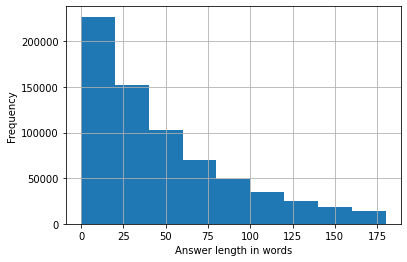

In [ ]:
ax = df['answer'].str.split(' ').str.len().hist(bins=range(0, 200, 20))
ax.set_xlabel('Answer length in words')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

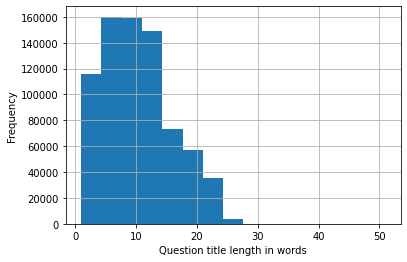

In [ ]:
ax = df['question'].str.split().str.len().hist(bins=15)
ax.set_xlabel('Question title length in words')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

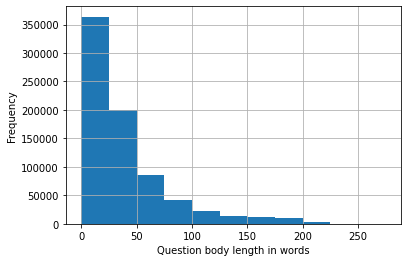

In [ ]:
ax = df['question2'].str.split().str.len().hist(bins=range(0,300, 25))
ax.set_xlabel('Question body length in words')
ax.set_ylabel('Frequency')

In [ ]:
df.count()

label        753655
question     753655
question2    753655
answer       753655
dtype: int64

In [ ]:
df.groupby('label').count()['question']

label
1     85299
2     67700
3     77872
4     68381
5     75536
6     65859
7     62915
8     80177
9     88434
10    81482
Name: question, dtype: int64

In [ ]:
# df['text'] = df['answer'].str.slice(start=0, stop=200)
# df['ShortDescription'] = df['ShortDescription'].str.split('-')

In [ ]:
# sampleSize = 7536
# dfMin = df.head(sampleSize)
dfMin = df

In [ ]:
dfMin.head()

,label,question,question2,answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
combined = list(dfMin[['question', 'question2', 'answer']].apply(lambda x: '. '.join(x), axis=1))
# combined = list(df[['question', 'question2', 'answer']].apply(lambda x: '. '.join(x), axis=1))

In [ ]:
# textEmbeddings = getDocumentEmbedding(list(dfMin['answer']))
textEmbeddings = getDocumentEmbedding(combined)

In [ ]:
# torch.save(textEmbeddings, 'YahooEmbeddingsFinal.pt')

In [ ]:
textEmbeddings = torch.load('YahooEmbeddingsFinal.pt')

In [ ]:
textEmbeddings.shape

torch.Size([753655, 512])

## Visualization

In [11]:
!pip install hdf5storage

In [13]:
import hdf5storage
mat = hdf5storage.loadmat('YahooDataset_sgtsnepi.mat')

In [14]:
embeddings2D = mat['Y']

In [15]:
embeddings2D.shape

(753655, 2)

In [38]:
dfBokeh = pd.DataFrame(data={
    'x': embeddings2D[:, 0],
    'y': embeddings2D[:, 1],
    'text': list(df['question']),
    'label': list(df['label']),
    'labelText': list(df['labelText'])
})

In [55]:
dfBokeh['color'] = 'black'
dfBokeh.loc[dfBokeh['label']==1   , 'color'] = 'lightcoral'
dfBokeh.loc[dfBokeh['label']==2   , 'color'] = 'khaki'
dfBokeh.loc[dfBokeh['label']==3   , 'color'] = 'lightskyblue'
dfBokeh.loc[dfBokeh['label']==4   , 'color'] = 'olive'
dfBokeh.loc[dfBokeh['label']==5   , 'color'] = 'red'
dfBokeh.loc[dfBokeh['label']==6   , 'color'] = 'thistle'
dfBokeh.loc[dfBokeh['label']==7   , 'color'] = 'mediumseagreen'
dfBokeh.loc[dfBokeh['label']==8   , 'color'] = 'sienna'
dfBokeh.loc[dfBokeh['label']==9   , 'color'] = 'navy'
dfBokeh.loc[dfBokeh['label']==10   , 'color'] = 'moccasin'

dfBokeh['size'] = 2

In [36]:
# Bokeh Libraries
from bokeh.io import output_notebook, output_file, save
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, OpenURL, TapTool
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models import TextInput, Button, Div, Slider, Paragraph
from bokeh.layouts import column, row
from bokeh import events
from bokeh.core.properties import value
from bokeh.events import MouseWheel
from bokeh.models.glyphs import Text, Circle, Glyph, ImageURL
from bokeh.util.browser import view
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, Turbo256



# Output thevisualization directly in the notebook
output_notebook()
output_file(basePath + 'YahooEmbeddings.html')

In [62]:
dfBokehSampled = dfBokeh.sample(200000)

In [ ]:
fig = figure(plot_height=850, plot_width=1000,
          match_aspect=True, title='2D embeddings of Yahoo!Answers Dataset documents')
# fig.title.text_font_style = 'bold'
# fig.title.align = 'center'

fig.xgrid.visible=False
fig.ygrid.visible=False

cds = ColumnDataSource(dfBokehSampled)
circleRenderer = fig.circle(x='x', y='y', legend='labelText', size=2, source=cds, color='color')

# # Format the tooltip
# tooltips = """
# <div style="width:400px;">
# @text
# </div>
# """
# # Add the HoverTool to the figure
# hover = HoverTool(tooltips=tooltips, renderers=[circleRenderer])
# fig.add_tools(hover)
show(fig)
save(fig)

## Evaluation

### Related sentences from training set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(dfMin, test_size=0.2)

In [ ]:
relatedSentencesArr  = []
relatedEmbeddings    = []
nRelatedSentencesArr = []
for (iTopic, topic) in enumerate(topics):
  print(topic)
  idx = list( train['label'] == iTopic+1 )
  relatedSentences = list(train[idx]['text'])
  relatedSentencesArr.append( relatedSentences )
  relatedEmbeddings.append( getEmbedding(relatedSentences) )
  nRelatedSentencesArr.append( len(relatedSentences) )

Society
Science
Health
Education
Computers
Sports
Business
Entertainment
Family
Politics


In [ ]:
nRelatedSentencesArr

[881, 719, 818, 723, 809, 670, 689, 895, 913, 883]

In [ ]:
dfMin = test
nSentences = len(dfMin)
textEmbeddings = getEmbedding(list(dfMin['text']))

In [ ]:
allEmbeddings = textEmbeddings
for (iTopic, topic) in enumerate(topics):
  print(topic)
  allEmbeddings = np.concatenate([allEmbeddings, relatedEmbeddings[iTopic]])

Society
Science
Health
Education
Computers
Sports
Business
Entertainment
Family
Politics


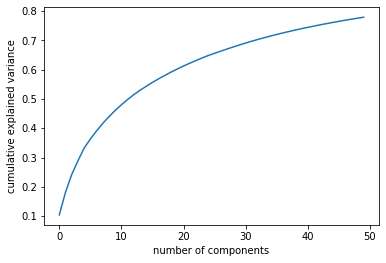

In [ ]:
pca = PCA(n_components=50)
embeddingsPCA = pca.fit_transform(allEmbeddings)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
# Unbalanced related sentences length
relatedEmbeddingsPCA = []
for (iTopic, topic) in enumerate(topics):
  relatedEmbeddingsPCA.append( torch.tensor(embeddingsPCA[nSentences + sum(nRelatedSentencesArr[0:iTopic]) : nSentences + sum(nRelatedSentencesArr[0:iTopic+1])]) )

embeddingsArr = torch.tensor(embeddingsPCA[0:nSentences])

In [ ]:
nSentences

2000

In [ ]:
### Mean over related sentences
probabilities = torch.zeros(size=(nSentences, len(topics)))
# Uncomment to avoid using PCA
# embeddingsArr = textEmbeddings

for (iTopic, topic) in enumerate(topics):
  print(topic)
  evaluationEmbeddings = relatedEmbeddingsPCA[iTopic]

  meanScore, std, proba = evaluateEmbeddingsMultiple(torch.tensor(embeddingsArr), torch.tensor(evaluationEmbeddings))


  probabilities[:, iTopic] = proba.T



ypred = torch.argmax(probabilities, dim=1) + 1

y = test['label']

Society


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Science
Health
Education
Computers
Sports
Business
Entertainment
Family
Politics


In [ ]:
print(accuracy_score(y, ypred))

0.4215


In [ ]:
print(precision_score(y, ypred, average=None))
print('Precision: {:0.3f}'.format(np.mean(precision_score(y, ypred, average='weighted'))))

print(recall_score(y, ypred, average=None))
print('Recall: {:0.3f}'.format(np.mean(recall_score(y, ypred, average='weighted'))))

print(f1_score(y, ypred, average=None))
print('F1: {:0.3f}'.format(np.mean(f1_score(y, ypred, average='weighted'))))

[0.63888889 0.33956386 0.5498008  0.35294118 0.4115942  0.51851852
 0.36842105 0.33121019 0.36543909 0.45669291]
Precision: 0.437
[0.20535714 0.5923913  0.64788732 0.02690583 0.77173913 0.37433155
 0.2        0.27659574 0.62318841 0.53953488]
Recall: 0.421
[0.31081081 0.43168317 0.59482759 0.05       0.536862   0.43478261
 0.25925926 0.30144928 0.46071429 0.49466951]
F1: 0.385


---

### Related Sentences from GPT-2

In [ ]:
# Generate new sentences from each topic
relatedEmbeddings = []
relatedSentencesArr = []
nRelatedSentences = 50
for (iTopic, topic) in enumerate(topics):
  print(topic)
  relatedSentences = []

  for label in topic[0:1]:
    print(label)
    # Baseline
    relatedSentences = []
    relatedSentences.append(label)
    nRelatedSentences = 1
    relatedSentencesArr.append(relatedSentences)

    # # Enrichment
    # relatedSentences = relatedSentences + generate(model, prompt='In other news, ' + label.lower(), n=40, nSentences = int(nRelatedSentences/len(topic)))
    # relatedSentencesArr.append(relatedSentences)
  # # relatedSentences = [x.replace('\n', ' ') for x in relatedSentences]

  relatedEmbeddings.append(getEmbedding(relatedSentences))

  # np.save(topic[0]+'_USE', relatedEmbeddings[iTopic])
  # with open(topic[0]+'USE_Raw.txt', 'w') as f:
  #   f.write( '\n'.join(relatedSentences) )

['Society', 'Culture']
Society
['Science', 'Mathematics']
Science
['Health']
Health
['Education', 'Reference']
Education
['Computers', 'Internet']
Computers
['Sports']
Sports
['Business', 'Finance']
Business
['Entertainment', 'Music']
Entertainment
['Family', 'Relationship']
Family
['Politics', 'Government']
Politics


In [ ]:
len(relatedEmbeddings[1])

1

In [ ]:
# Used saved sentences
relatedEmbeddings = []
relatedSentencesArr = []

for (iTopic, topic) in enumerate(topics):
  relatedEmbeddings.append(np.load(topic[0]+'_USE.npy'))

  with open(topic[0]+'USE_Raw.txt', 'r') as f:
    relatedSentencesArr.append(f.readlines())

In [ ]:
len(relatedEmbeddings[0])

50

### PCA

In [ ]:
allEmbeddings = textEmbeddings

for (iTopic, topic) in enumerate(topics):
  allEmbeddings = np.concatenate([allEmbeddings, relatedEmbeddings[iTopic]])
print(allEmbeddings.shape)

(753665, 512)


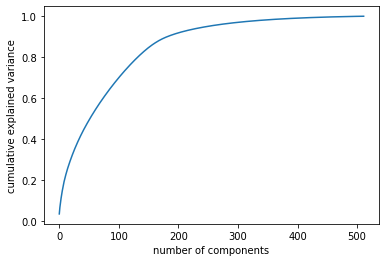

In [ ]:
pca = PCA(n_components=512)
embeddingsPCA = pca.fit_transform(allEmbeddings)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
nRelatedSentences = len(relatedEmbeddings[0])
print(nRelatedSentences)
nSentences = len(df)#len(dfMin)
nTopics = len(topics)

1


In [ ]:
nSentences

753655

In [ ]:
relatedEmbeddingsPCA = []
for (iTopic, topic) in enumerate(topics):
  relatedEmbeddingsPCA.append( torch.tensor(embeddingsPCA[nSentences + iTopic*nRelatedSentences : nSentences+(iTopic+1)*nRelatedSentences]) )

embeddingsArr = torch.tensor(embeddingsPCA[0:nSentences])

### Average of related sentences

In [ ]:
# probabilitiesQ = torch.zeros(size=(nSentences, nTopics))
probabilities = torch.zeros(size=(nSentences, nTopics))

for (iTopic, topic) in enumerate(topics):
  print(topic)
  evaluationEmbeddings = relatedEmbeddingsPCA[iTopic]

  meanScore, std, proba = evaluateEmbeddingsMultiple(embeddingsArr, evaluationEmbeddings)
  # meanScore, std, probaQ = evaluateEmbeddingsMultiple(embeddingsArrQ, evaluationEmbeddings)


  probabilities[:, iTopic]  = proba.T
  # probabilitiesQ[:, iTopic] = probaQ.T
  # probabilitiesTotal        = (probabilities + probabilitiesQ)/2



ypred = torch.argmax(probabilities, dim=1) + 1
# ypredQ = torch.argmax(probabilitiesQ, dim=1) + 1
# ypredTotal = torch.argmax(probabilitiesTotal, dim=1) + 1

# y = dfMin['label']
y = df['label']

['Society', 'Culture']
['Science', 'Mathematics']
['Health']
['Education', 'Reference']
['Computers', 'Internet']
['Sports']
['Business', 'Finance']
['Entertainment', 'Music']
['Family', 'Relationship']
['Politics', 'Government']


In [ ]:
print(accuracy_score(y, ypred))

0.43155953320816554


In [ ]:
cm = confusion_matrix(y, ypred)
cmNorm = torch.tensor(data=cm, dtype=float)
for i in range(len(cm)):
  cmNorm[i, :] = cmNorm[i, :]/torch.sum(cmNorm[i, :])

Text(123.0, 0.5, 'Actual')

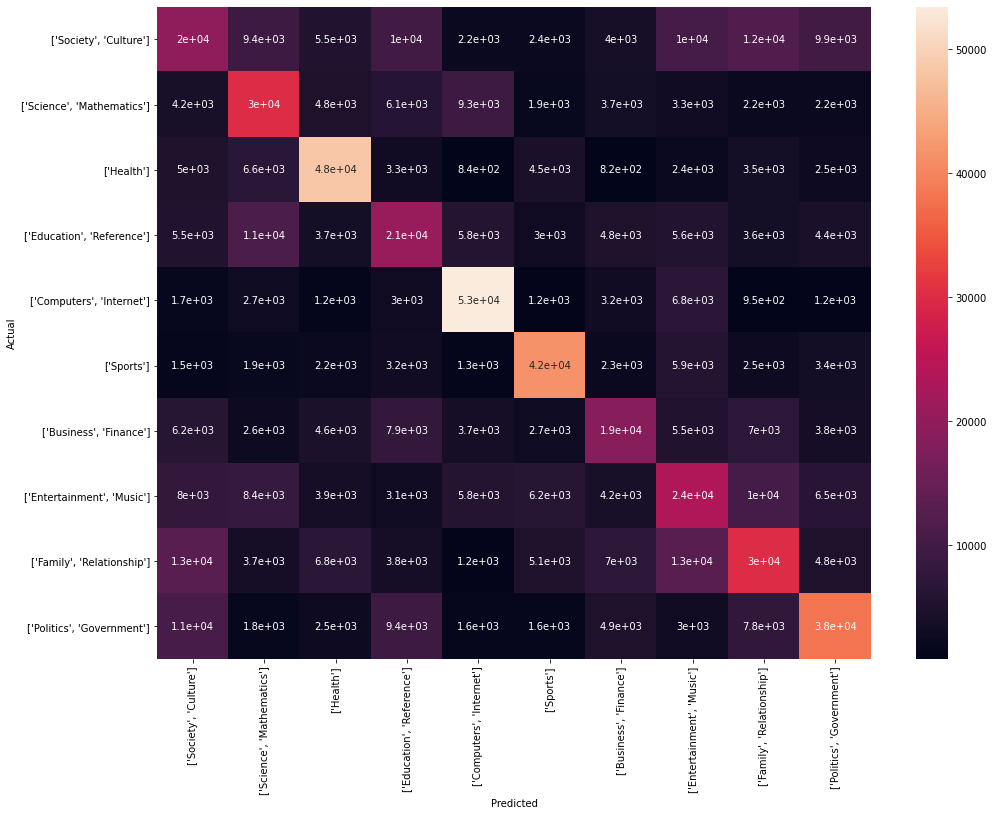

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, xticklabels=topics, yticklabels=topics)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print(precision_score(y, ypred, average=None))
print('Precision: {:0.3f}'.format(np.mean(precision_score(y, ypred, average='weighted'))))

print(recall_score(y, ypred, average=None))
print('Recall: {:0.3f}'.format(np.mean(recall_score(y, ypred, average='weighted'))))

print(f1_score(y, ypred, average=None))
print('F1: {:0.3f}'.format(np.mean(f1_score(y, ypred, average='weighted'))))

[0.23683287 0.41458999 0.46039013 0.27591206 0.66945096 0.58811072
 0.44680245 0.5184895  0.45411242 0.48627845]
Precision: 0.460
[0.22577406 0.56691423 0.70207922 0.1729255  0.75842637 0.80831601
 0.19436183 0.5830837  0.60963479 0.46399489]
Recall: 0.473
[0.23117128 0.47893215 0.55610988 0.21260356 0.7111665  0.68085106
 0.2708864  0.54889276 0.52050473 0.4748754 ]
F1: 0.449


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: ignored

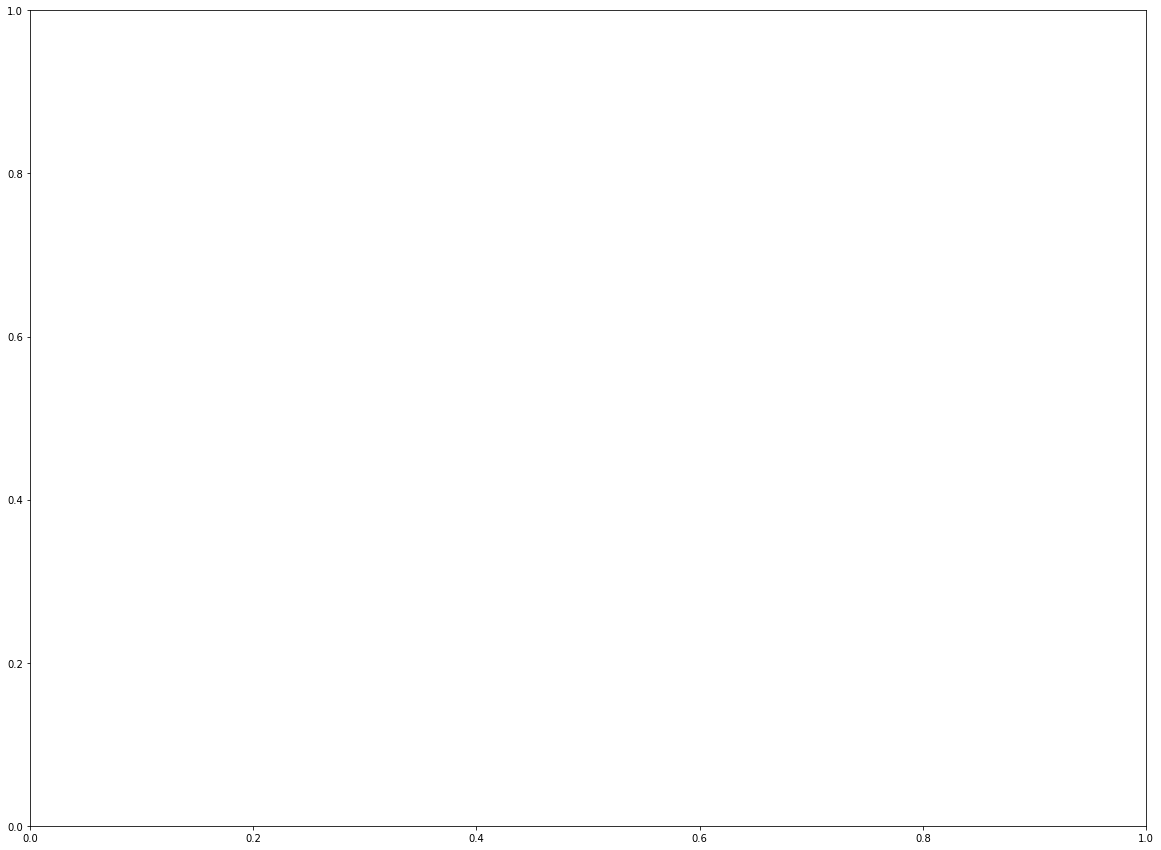

In [ ]:
plt.figure(figsize=(20, 15))
plt.bar(topics, np.diag(cm))

In [ ]:
p = probabilitiesDescription
print(p.shape)
classIdx = 10
idx = list(dfMin['label'] == classIdx)
idxNot = [not x for x in idx]

torch.Size([10000, 10])


(0.0, 1000.0)

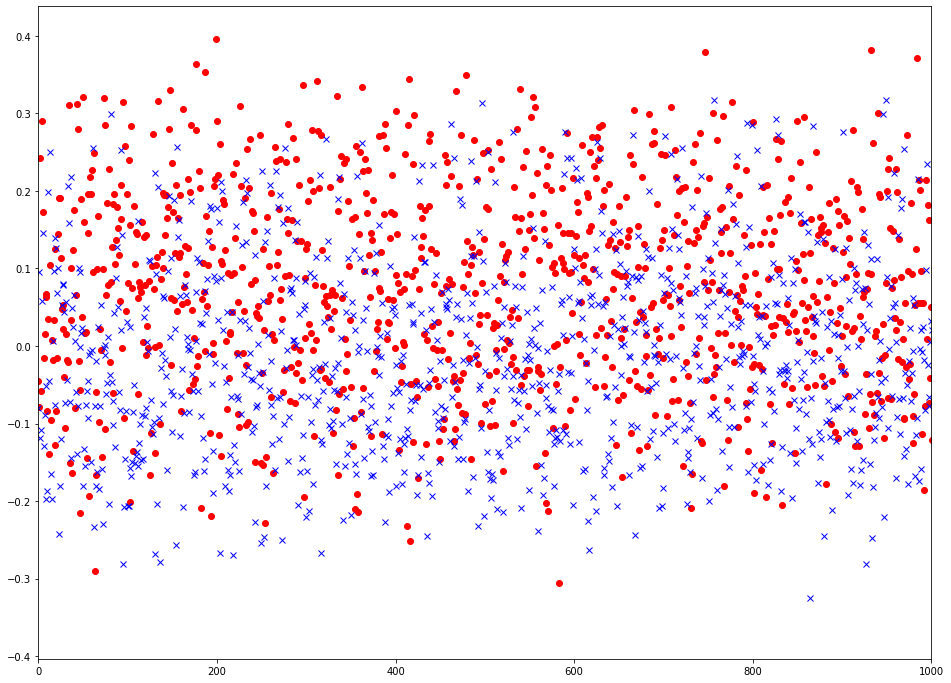

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(p[idx, classIdx-1], 'ro')
plt.plot(p[idxNot, classIdx-1], 'bx')
plt.xlim([0, 1000])

#### kNN with cosine

In [ ]:
# Construct distances matrix
X = torch.zeros(size=(nSentences, len(topics) * nRelatedSentences))

start = 0
for (iTopic, topic) in enumerate(topics):
  print(topic)

  relatedEmbeddingsArr = relatedEmbeddingsPCA[iTopic]

  for iSentence in range(nSentences):
    nextFree = start
    for iKeyword in range(nRelatedSentences):
      X[iSentence][nextFree] = getSimilarity(embeddingsArr[iSentence], relatedEmbeddingsArr[iKeyword])
      nextFree += 1

  start += nRelatedSentences

Society
Science
Health
Education
Computers
Sports
Business
Entertainment
Family
Politics


In [ ]:
ypred = np.zeros((nSentences, ))
y = np.asarray(dfMin['label'])

acc  = []
prec = []
rec  = []
f1   = []
rng = range(1, 200, 10)
for k in rng:
  for i in range(nSentences):
    idx = np.argpartition(X[i, :], -k)[-k:]

    tmpIdx = idx.clone().detach()

    tmpIdx[idx>=9*nRelatedSentences] = 10
    idx[idx>=9*nRelatedSentences] = -1

    tmpIdx[idx>=8*nRelatedSentences] = 9
    idx[idx>=8*nRelatedSentences] = -1

    tmpIdx[idx>=7*nRelatedSentences] = 8
    idx[idx>=7*nRelatedSentences] = -1

    tmpIdx[idx>=6*nRelatedSentences] = 7
    idx[idx>=6*nRelatedSentences] = -1

    tmpIdx[idx>=5*nRelatedSentences] = 6
    idx[idx>=5*nRelatedSentences] = -1

    tmpIdx[idx>=4*nRelatedSentences] = 5
    idx[idx>=4*nRelatedSentences] = -1
    
    tmpIdx[idx>=3*nRelatedSentences] = 4
    idx[idx>=3*nRelatedSentences] = -1

    tmpIdx[idx>=2*nRelatedSentences] = 3
    idx[idx>=2*nRelatedSentences] = -1

    tmpIdx[idx>=1*nRelatedSentences] = 2
    idx[idx>=1*nRelatedSentences] = -1

    tmpIdx[idx>=0*nRelatedSentences] = 1
    idx[idx>=0*nRelatedSentences] = -1

    ypred[i] = torch.mode(tmpIdx).values.item()

  acc.append(accuracy_score(y, ypred))
  prec.append(precision_score(y, ypred, average='weighted'))
  rec.append(recall_score(y, ypred, average='weighted'))
  f1.append(f1_score(y, ypred, average='weighted'))


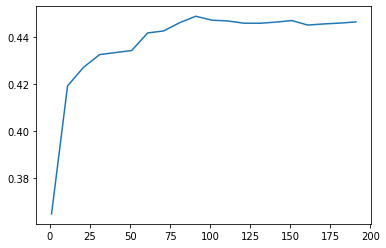

In [ ]:
plt.plot(rng, f1)

In [ ]:
idx = np.argmax(f1)
k = rng[idx]

print(k)
print('Precision: {:0.3f}'.format(prec[idx]))
print('Recall: {:0.3f}'.format(rec[idx]))
print('F1: {:0.3f}'.format(f1[idx]))


91
Precision: 0.459
Recall: 0.453
F1: 0.449


#### kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
nRelatedSentencesArr = [nRelatedSentences]*nTopics
X = np.zeros((sum(nRelatedSentencesArr), 50))
ytrain = np.zeros((sum(nRelatedSentencesArr), 1))
for (iTopic, topic) in enumerate(topics):
  X[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1]), :] = relatedEmbeddingsPCA[iTopic]
  ytrain[sum(nRelatedSentencesArr[0:iTopic]) : sum(nRelatedSentencesArr[0:iTopic+1])] = iTopic + 1

In [ ]:
acc = []
for k in range(2, 100, 5):
  knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
  knn.fit(X, ytrain)
  ypred = knn.predict(embeddingsArr)
  acc.append(accuracy_score(y, ypred))

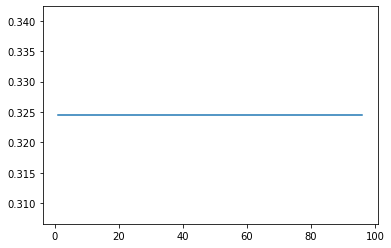

In [ ]:
plt.plot(range(1, 100, 5), acc)